## Functions

In [25]:
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.metrics import mean_squared_error

In [89]:
def plot_time_comparison(seegprep_signal, fieldtrip_signal, srate, seconds=60):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    time = np.arange(0,len(seegprep_signal))/srate

    axs[0].plot(time[0:srate*seconds], seegprep_signal[0:srate*seconds], 'b', linewidth=0.1)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude ($\mu$V)')
    axs[0].set_title('sEEGPrep Output')

    axs[1].plot(time[0:srate*seconds], fieldtrip_signal[0:srate*seconds], 'b', linewidth=0.1)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude ($\mu$V)')
    axs[1].set_title('Fieldtrip Output')

    plt.tight_layout()

In [90]:
def plot_freq_comp(seegprep_signal, fieldtrip_signal, srate, titles=['sEEGPrep Output', 'Fieldtrip Output']):
    # Freq domain response
    length_segment = 3.0
    f_seegpre, welchpow_seegprep = welch(seegprep_signal, fs=srate, nperseg=int(length_segment*srate))
    f_ft, welchpow_ft = welch(fieldtrip_signal, fs=srate, nperseg=int(length_segment*srate))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    # Plot until 200 hz
    if srate > 200:
        f_max = f_ft.tolist().index(100)
    else:
        f_max = len(f_ft)
        
    axs[0].plot(f_seegpre[0:f_max], welchpow_seegprep[0:f_max], 'b', linewidth=0.8)
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
    axs[0].set_title(titles[0])

    axs[1].plot(f_ft[0:f_max], welchpow_ft[0:f_max], 'b', linewidth=0.8)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
    axs[1].set_title(titles[1])

    plt.tight_layout()


In [23]:
def plot_stft_comp(seegprep_signal, fieldtrip_signal, srate, nperseg, seconds=60, freq_range = [0,20]):
    # Freq domain response
    length_segment = 3.0
    f_s, t_s, Zxx_seegprep = scipy.signal.stft(seegprep_signal[0:seconds*srate], fs=srate, nperseg=nperseg)
    f_ft, t_ft, Zxx_ft = scipy.signal.stft(fieldtrip_signal[0:seconds*srate], fs=srate, nperseg=nperseg)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    # Plot until 100 hz
    f_max = np.argmin(np.abs(f_ft-freq_range[-1]))
    f_min = np.argmin(np.abs(f_ft-freq_range[0]))
    
    vmin=min(np.min(np.abs(Zxx_seegprep[f_min:f_max,:])), np.min(np.abs(Zxx_ft[f_min:f_max,:])))
    vmax=min(np.max(np.abs(Zxx_seegprep[f_min:f_max,:])), np.max(np.abs(Zxx_ft[f_min:f_max,:])))
        
    c = axs[0].pcolormesh(t_s, f_s[f_min:f_max], np.abs(Zxx_seegprep)[f_min:f_max,:], vmin=vmin, vmax=vmax)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Frequency (Hz)')
    axs[0].set_title('sEEGPrep Output - STFT Magnitude')
    plt.colorbar(c, ax=axs[0], label='Amplitude ($\mu$V)')

    axs[1].pcolormesh(t_ft, f_ft[f_min:f_max], np.abs(Zxx_ft)[f_min:f_max,:], vmin=vmin, vmax=vmax)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_title('Fieldtrip Output - STFT Magnitude')
    plt.colorbar(c, ax=axs[1], label='Amplitude ($\mu$V)') 
    # plt.colorbar(z1_plot,cax=axs[1])

    plt.tight_layout()


In [35]:
def get_RMSE(seegprep_signal, fieldtrip_signal, srate):
    time_rmse = np.sqrt(mean_squared_error(seegprep_signal, fieldtrip_signal))
    
    # Freq
    length_segment = 3.0
    f_seegpre, welchpow_seegprep = welch(seegprep_signal, fs=srate, nperseg=int(length_segment*srate))
    f_ft, welchpow_ft = welch(fieldtrip_signal, fs=srate, nperseg=int(length_segment*srate))
    
    freq_rmse = np.sqrt(mean_squared_error(welchpow_seegprep, welchpow_ft))
    
    return {
        'Time RMSE (uV)': time_rmse,
        'Freq RMSE (uV^2/Hz)': freq_rmse
    }

In [86]:
import matplotlib
font = {'size'   : 12}
matplotlib.rc('font', **font)

## Epoching

In [29]:
import pyedflib
import numpy as np

In [87]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-clip_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2')
    chn_sig = edf_epoch.readSignal(idx)

In [88]:
# Fieldtrip file
data_fieldtrip = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/epoching.mat')['signals']

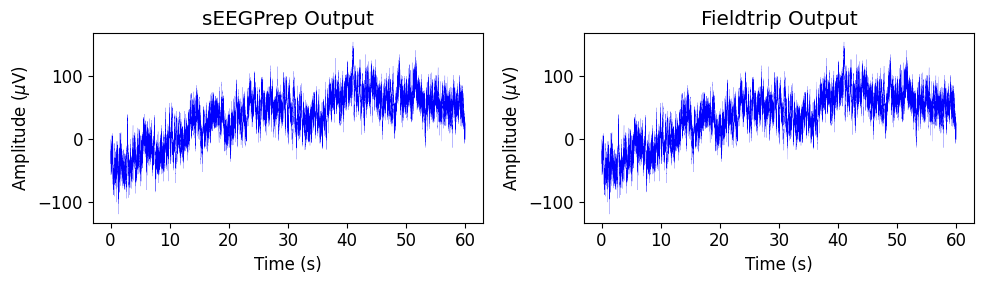

In [91]:
plot_time_comparison(chn_sig, data_fieldtrip[0,:], srate=2048)

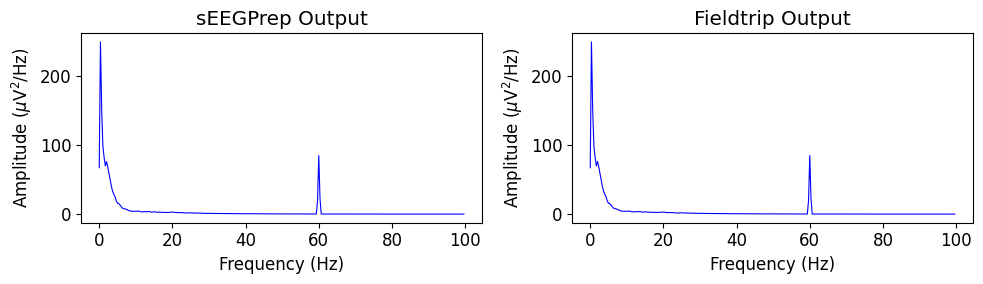

In [92]:
plot_freq_comp(chn_sig, data_fieldtrip[0,:], srate=2048)

In [36]:
get_RMSE(chn_sig, data_fieldtrip[0,:], srate=2048)

{'Time RMSE (uV)': 0.14057072407616472,
 'Freq RMSE (uV^2/Hz)': 0.0011897984793740359}

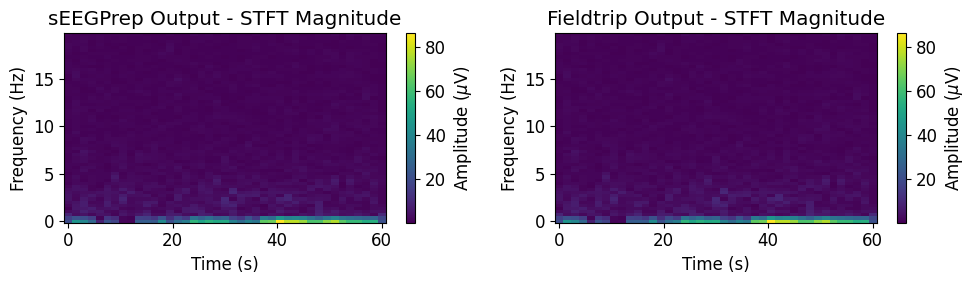

In [37]:
plot_stft_comp(chn_sig, data_fieldtrip[0,:], srate=2048, nperseg=3*2048)

## Downsampling

In [93]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-dn_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2')
    chn_sig = edf_epoch.readSignal(idx)
# Fieldtrip file
data_fieldtrip = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/Downsampling.mat')['signals']

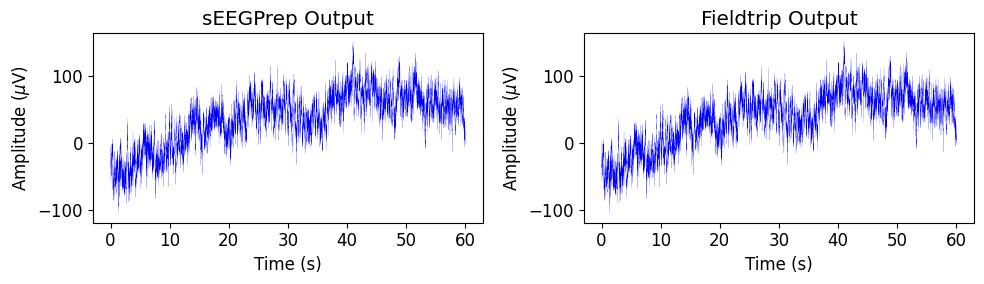

In [94]:
plot_time_comparison(chn_sig, data_fieldtrip[0,:], srate=200)

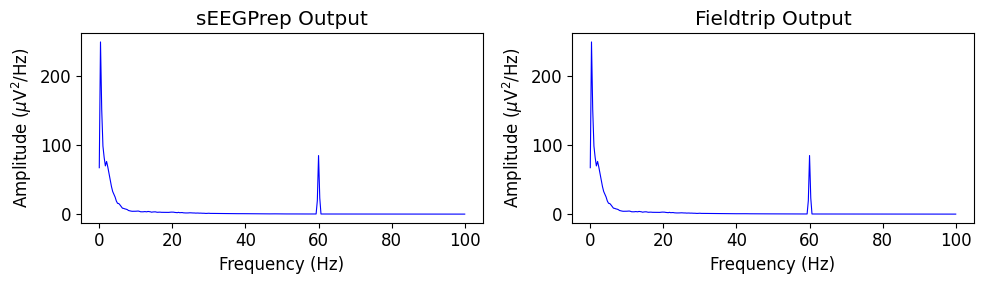

In [95]:
plot_freq_comp(chn_sig, data_fieldtrip[0,:], srate=200)

In [84]:
get_RMSE(chn_sig, data_fieldtrip[0,:], srate=2048)

{'Time RMSE (uV)': 0.3653503250582439,
 'Freq RMSE (uV^2/Hz)': 0.047262932170011145}

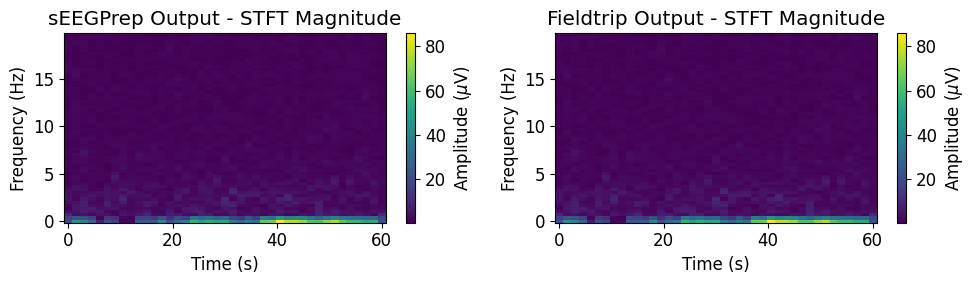

In [85]:
plot_stft_comp(chn_sig, data_fieldtrip[0,:], srate=200, nperseg=3*200)

## Highpass filtering

In [96]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-filt_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2')
    chn_sig = edf_epoch.readSignal(idx)
# Fieldtrip file
data_fieldtrip = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/Highpass.mat')['signals']

In [97]:
np.mean(chn_sig), np.mean(data_fieldtrip)

(-0.024618139798072373, -3.0884924247705687e-15)

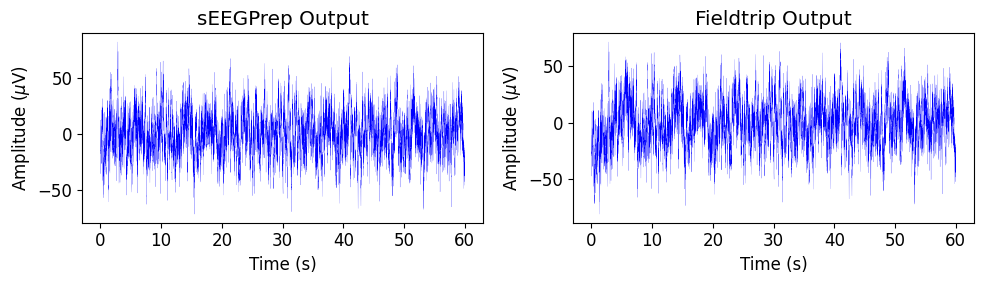

In [98]:
plot_time_comparison(chn_sig, data_fieldtrip[0,:], srate=200)

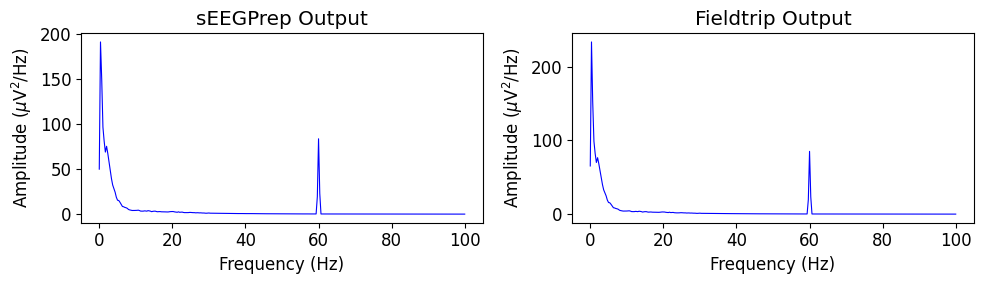

In [99]:
plot_freq_comp(chn_sig, data_fieldtrip[0,:], srate=200)

In [100]:
get_RMSE(chn_sig, data_fieldtrip[0,:], srate=2048)

{'Time RMSE (uV)': 7.4575572680068865,
 'Freq RMSE (uV^2/Hz)': 1.8751880478063834}

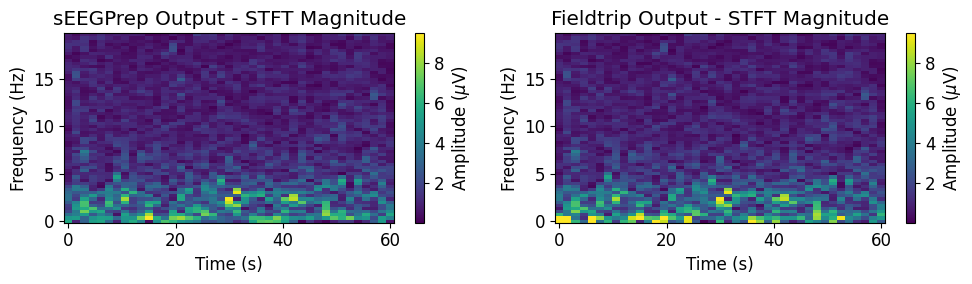

In [101]:
plot_stft_comp(chn_sig, data_fieldtrip[0,:], srate=200, nperseg=3*200)

## Reref

In [102]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-reref_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2-3')
    chn_sig = edf_epoch.readSignal(idx)
# Fieldtrip file
data_fieldtrip = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/Reref.mat')['signals']

In [103]:
np.mean(chn_sig), np.mean(data_fieldtrip)

(-0.6009872224765382, 1.1084466677857563e-15)

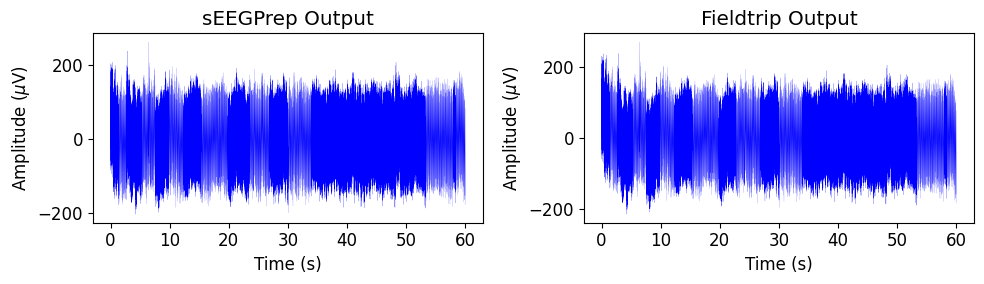

In [104]:
plot_time_comparison(chn_sig, data_fieldtrip[0,:], srate=200, seconds=60)

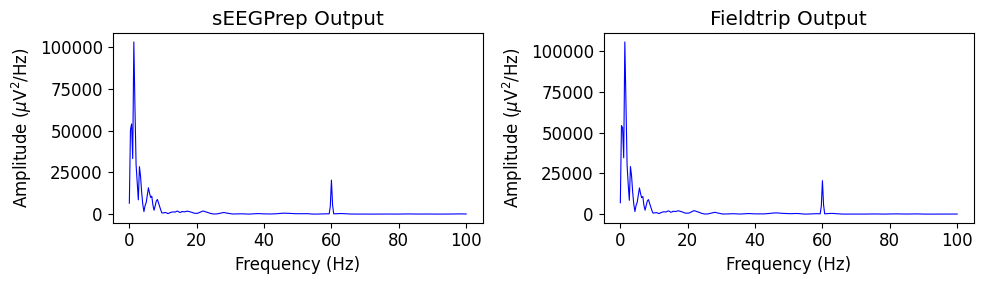

In [105]:
plot_freq_comp(chn_sig, data_fieldtrip[0,:], srate=200)

In [106]:
get_RMSE(chn_sig, data_fieldtrip[0,:], srate=2048)

{'Time RMSE (uV)': 80.26483582628906,
 'Freq RMSE (uV^2/Hz)': 204.71837328018316}

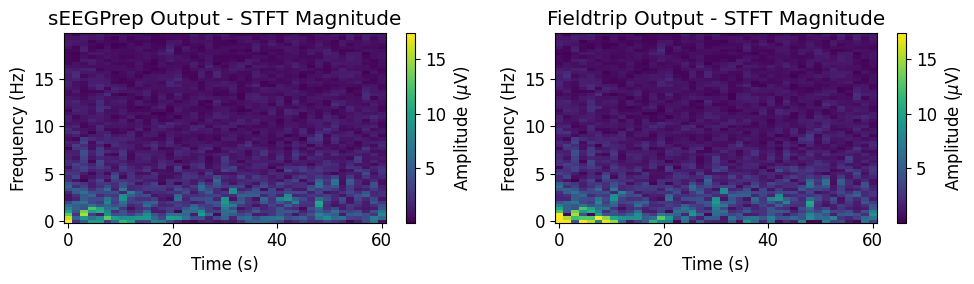

In [107]:
plot_stft_comp(chn_sig, data_fieldtrip[0,:], srate=200, nperseg=3*200)

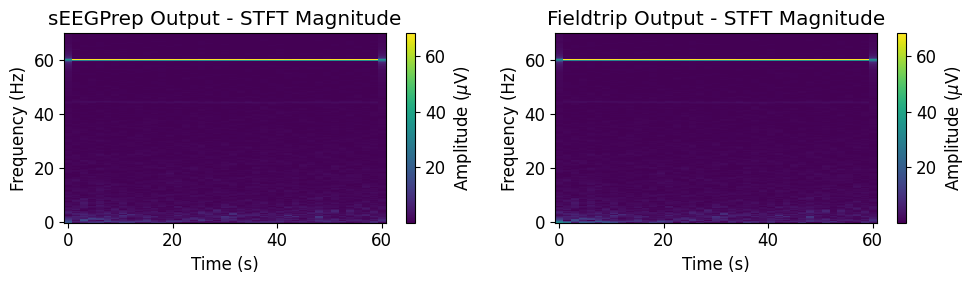

In [108]:
plot_stft_comp(chn_sig, data_fieldtrip[0,:], srate=200, nperseg=3*200, freq_range=[0,70], seconds=60)

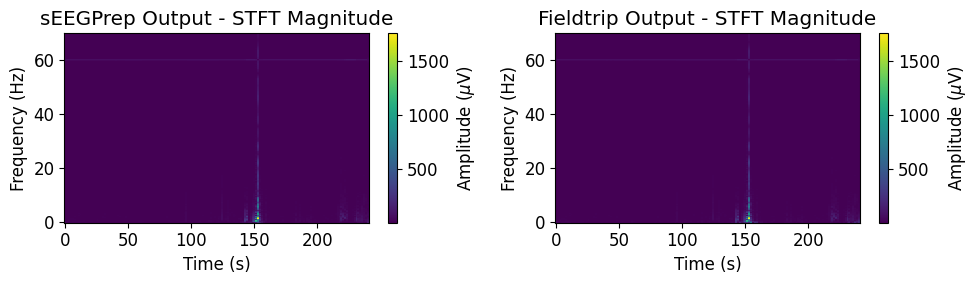

In [109]:
plot_stft_comp(chn_sig, data_fieldtrip[0,:], srate=200, nperseg=3*200, freq_range=[0,70], seconds=360)

## PLI 

In [110]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-PLI_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2-3')
    chn_sig = edf_epoch.readSignal(idx)
# Fieldtrip file
data_fieldtrip = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/cleanline.mat')['signals'].squeeze()

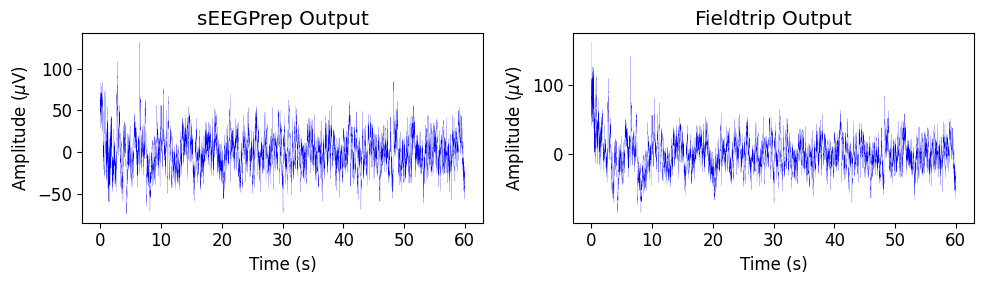

In [111]:
plot_time_comparison(chn_sig, data_fieldtrip, srate=200)

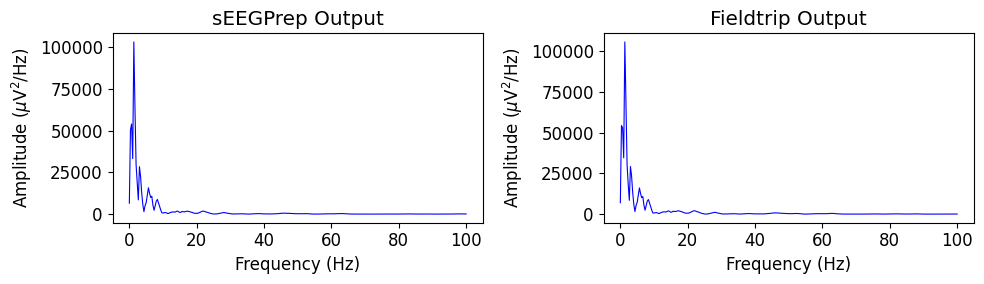

In [112]:
plot_freq_comp(chn_sig, data_fieldtrip, srate=200)

In [113]:
get_RMSE(chn_sig, data_fieldtrip, srate=2048)

{'Time RMSE (uV)': 80.54319193321881,
 'Freq RMSE (uV^2/Hz)': 204.71488413303084}

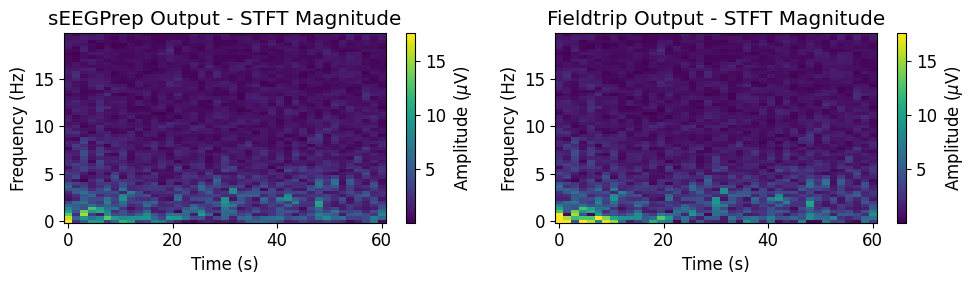

In [114]:
plot_stft_comp(chn_sig, data_fieldtrip, srate=200, nperseg=3*200)

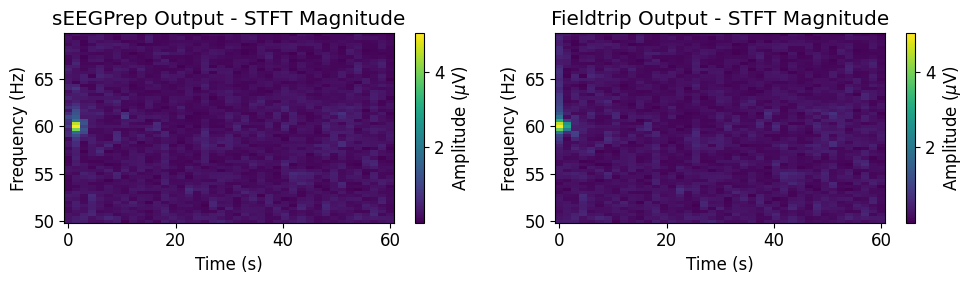

In [115]:
plot_stft_comp(chn_sig, data_fieldtrip, srate=200, nperseg=3*200, freq_range=[50,70], seconds=60)

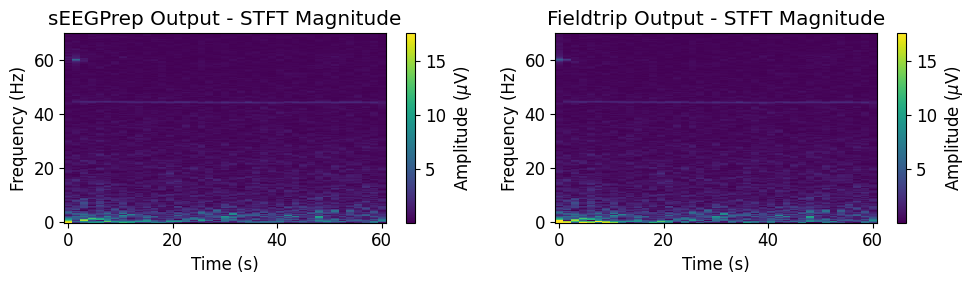

In [116]:
plot_stft_comp(chn_sig, data_fieldtrip, srate=200, nperseg=3*200, freq_range=[0,70], seconds=60)

### Comparison for different methods

In [117]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import permutation_test
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection
from statannotations.Annotator import Annotator

In [118]:
mat_contents = sio.loadmat('PLI_results_Python.mat')
zapline_python = mat_contents['y1']
cleanline_python = mat_contents['y2']
removePLI_python = mat_contents['y3']
zapline_python.shape, cleanline_python.shape, removePLI_python.shape

((48000, 100), (48000, 100), (48000, 100))

In [119]:
mat_contents = sio.loadmat('PLI_results_matlab.mat')
zapline_matlab = mat_contents['y1']
cleanline_matlab = mat_contents['y2']
removePLI_matlab = mat_contents['y3']
zapline_matlab.shape, cleanline_matlab.shape, removePLI_matlab.shape

((48000, 100), (48000, 100), (48000, 100))

In [120]:
mat_contents = sio.loadmat('PLI_test_signals.mat')
eeg_signal_a = mat_contents['eeg_signal_a']
eeg_signal_b = mat_contents['eeg_signal_b']
eeg_signal = mat_contents['noisy_signal']
s = mat_contents['clean_signal']
eeg_signal_a.shape, eeg_signal_b.shape, eeg_signal.shape, s.shape

((48000, 100), (48000, 100), (48000, 100), (48000, 100))

In [121]:
signal_idx = 90

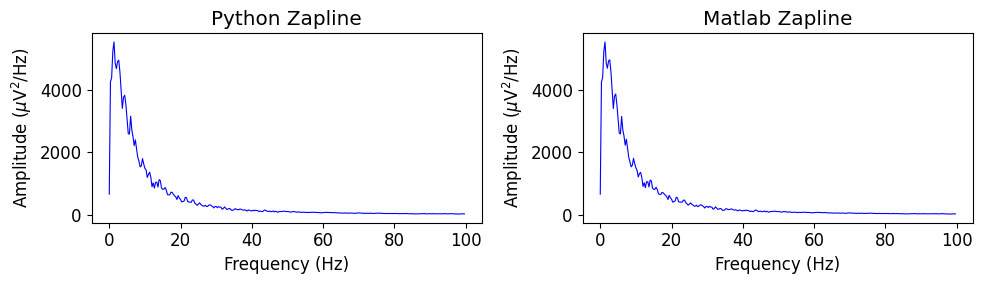

In [122]:
plot_freq_comp(zapline_python[:,signal_idx], zapline_matlab[:,signal_idx], srate=400,titles=['Python Zapline', 'Matlab Zapline'])

In [75]:
from utils import compute_metrics

In [76]:
dict_total = []
for y_python, y_matlab, method in [(zapline_python, zapline_matlab, 'Zapline'),
                                   (cleanline_python, cleanline_matlab, 'Cleanline'),
                                   (removePLI_python, removePLI_matlab, 'removePLI')
                                   ]:
    for y, language in zip([y_python, y_matlab], ['Python', 'Matlab']):
        for ind in range(y.shape[-1]):
            metrics = compute_metrics(s[:,ind], y[:,ind], eeg_signal_a[:,ind], srate=400)
            for metric in metrics:
                metric_dict =  dict()
                metric_dict['Metric']=metric
                metric_dict['Value']=metrics[metric]
                metric_dict['chn']=ind
                metric_dict['Method']=method
                metric_dict['Language'] = language
                dict_total.append(metric_dict)

In [77]:
df = pd.DataFrame(dict_total)
df.tail()

,Metric,Value,chn,Method,Language
2995,SNR (dB),25.513512,99,removePLI,Matlab
2996,RMSE - Time Domain ($\mu$V),12.219366,99,removePLI,Matlab
2997,Correlation coefficient,0.998767,99,removePLI,Matlab
2998,Spectral error ($\mu$V$^2$/Hz),18.673663,99,removePLI,Matlab
2999,Attenuation (dB),-5.983265,99,removePLI,Matlab


In [78]:
df.Metric.unique()

array(['SNR (dB)', 'RMSE - Time Domain ($\\mu$V)',
       'Correlation coefficient', 'Spectral error ($\\mu$V$^2$/Hz)',
       'Attenuation (dB)'], dtype=object)

Zapline
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Spectral error ($\mu$V$^2$/Hz)_Python vs. Spectral error ($\mu$V$^2$/Hz)_Matlab: Custom statistical test, P_val:1.000e-05
RMSE - Time Domain ($\mu$V)_Python vs. RMSE - Time Domain ($\mu$V)_Matlab: Custom statistical test, P_val:1.000e-05


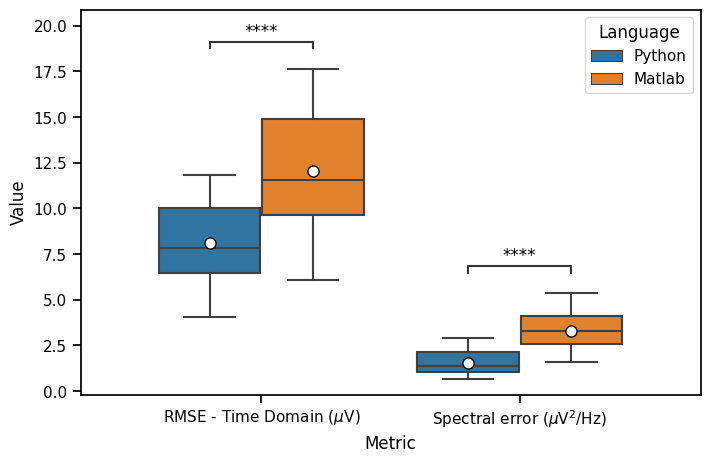

Cleanline
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Spectral error ($\mu$V$^2$/Hz)_Python vs. Spectral error ($\mu$V$^2$/Hz)_Matlab: Custom statistical test, P_val:1.000e-05
RMSE - Time Domain ($\mu$V)_Python vs. RMSE - Time Domain ($\mu$V)_Matlab: Custom statistical test, P_val:1.000e-05


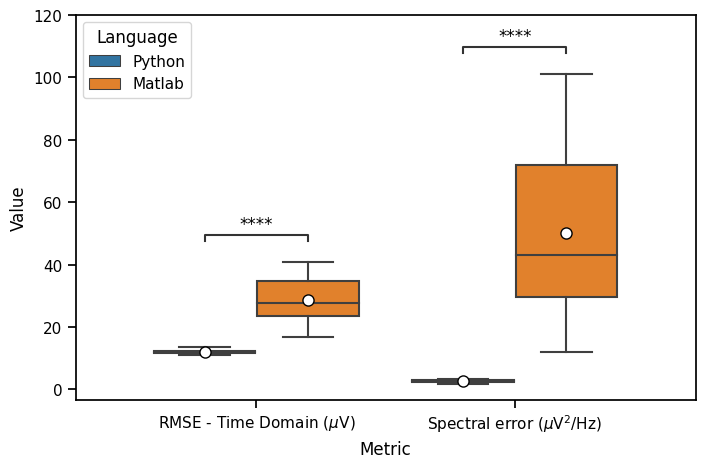

removePLI
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Spectral error ($\mu$V$^2$/Hz)_Python vs. Spectral error ($\mu$V$^2$/Hz)_Matlab: Custom statistical test, P_val:4.493e-01
RMSE - Time Domain ($\mu$V)_Python vs. RMSE - Time Domain ($\mu$V)_Matlab: Custom statistical test, P_val:2.838e-01


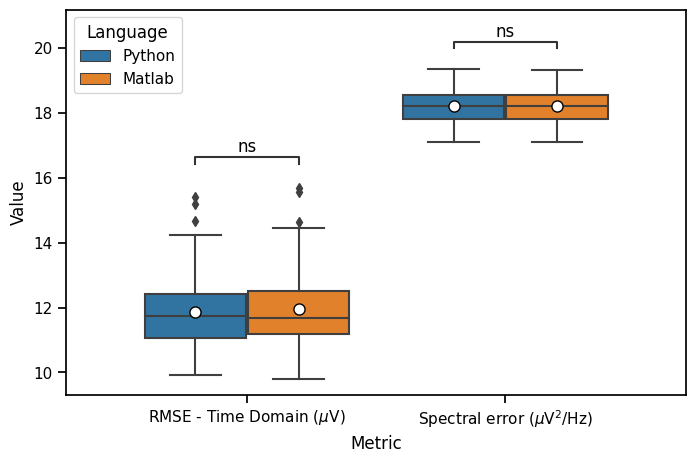

In [79]:
# Generate pairs
elements = df.Language.unique()

# Generate combinations of length 2 without repetition
combinations_without_repetition = list(combinations(elements, 2))

# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    # return np.median(x, axis=axis) - np.median(y, axis=axis)

df_metrics = df.loc[(df.Metric=='RMSE - Time Domain ($\\mu$V)').astype(bool)+
                    (df.Metric=='Spectral error ($\\mu$V$^2$/Hz)').astype(bool)]
for method in df.Method.unique():
    print(method)
    df_tmp = df_metrics.loc[df_metrics.Method==method]

    pairs=[]
    p_vals = []
    for metric in df_tmp.Metric.unique():
        p_vals_tmp = []
        for element_1, element_2 in combinations_without_repetition:
            # print(f'\n Comparison between {net_1} and {net_2}\n')
            x = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Language == element_1).astype(bool),'Value'].values
            y = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Language == element_2).astype(bool),'Value'].values 
            base = statistic(x, y, 0) # Small network has worst performance
            # Permutation testing
            res = permutation_test((x, y), statistic, vectorized=True,
                               n_resamples=100000, alternative='less' if base<0 else 'greater')
            # print('Real diff',res.statistic)
            # print('p-val: ', res.pvalue)
            p_vals_tmp.append(res.pvalue)
            pairs.append([(metric, element_1), (metric, element_2)])
        # Correct them
        significance, corr_p_vals = fdrcorrection(p_vals_tmp)
        p_vals += corr_p_vals.tolist()

    # Plot params
    plotting_parameters = {
        'data': df_tmp,
        'y': "Value",
        'x': "Metric",
        'hue':'Language'
    }
    # sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
    with sns.plotting_context('notebook', font_scale = 1):
        # Create new plot
        ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
        # Plot with seaborn
        ax = sns.boxplot(**plotting_parameters, showmeans=True,
                meanprops={'marker':'o',
                           'markerfacecolor':'white', 
                           'markeredgecolor':'black',
                           'markersize':'8'})

        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        annotator.configure(text_format="star")
        annotator.set_pvalues_and_annotate(p_vals)
        # Label and show
        plt.show()

Zapline
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Attenuation (dB)_Python vs. Attenuation (dB)_Matlab: Custom statistical test, P_val:4.739e-01
SNR (dB)_Python vs. SNR (dB)_Matlab: Custom statistical test, P_val:1.000e-05


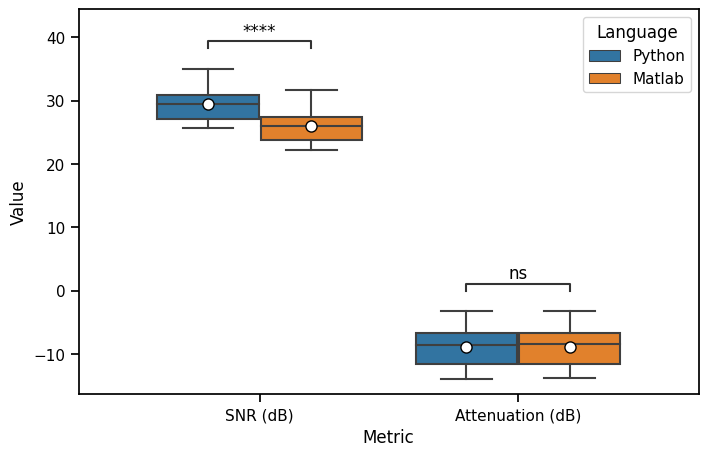

Cleanline
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Attenuation (dB)_Python vs. Attenuation (dB)_Matlab: Custom statistical test, P_val:1.000e-05
SNR (dB)_Python vs. SNR (dB)_Matlab: Custom statistical test, P_val:1.000e-05


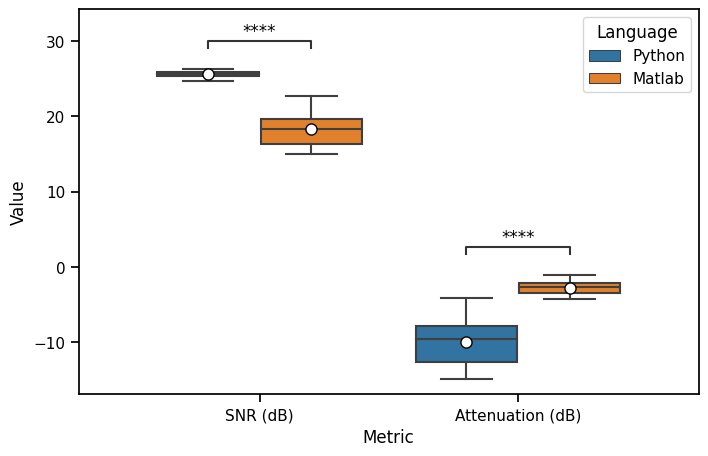

removePLI
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Attenuation (dB)_Python vs. Attenuation (dB)_Matlab: Custom statistical test, P_val:4.486e-01
SNR (dB)_Python vs. SNR (dB)_Matlab: Custom statistical test, P_val:2.806e-01


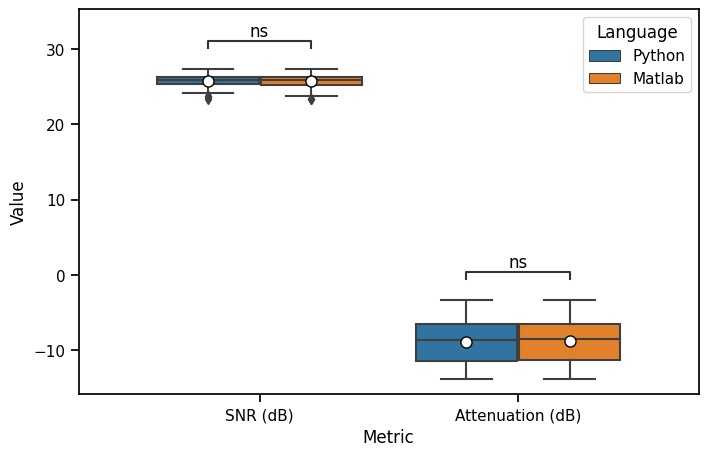

In [80]:
# Generate pairs
elements = df.Language.unique()

# Generate combinations of length 2 without repetition
combinations_without_repetition = list(combinations(elements, 2))

# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    # return np.median(x, axis=axis) - np.median(y, axis=axis)

df_metrics = df.loc[(df.Metric=='SNR (dB)').astype(bool)+
                    (df.Metric=='Attenuation (dB)').astype(bool)]
for method in df.Method.unique():
    print(method)
    df_tmp = df_metrics.loc[df_metrics.Method==method]

    pairs=[]
    p_vals = []
    for metric in df_tmp.Metric.unique():
        p_vals_tmp = []
        for element_1, element_2 in combinations_without_repetition:
            # print(f'\n Comparison between {net_1} and {net_2}\n')
            x = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Language == element_1).astype(bool),'Value'].values
            y = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Language == element_2).astype(bool),'Value'].values 
            base = statistic(x, y, 0) # Small network has worst performance
            # Permutation testing
            res = permutation_test((x, y), statistic, vectorized=True,
                               n_resamples=100000, alternative='less' if base<0 else 'greater')
            # print('Real diff',res.statistic)
            # print('p-val: ', res.pvalue)
            p_vals_tmp.append(res.pvalue)
            pairs.append([(metric, element_1), (metric, element_2)])
        # Correct them
        significance, corr_p_vals = fdrcorrection(p_vals_tmp)
        p_vals += corr_p_vals.tolist()

    # Plot params
    plotting_parameters = {
        'data': df_tmp,
        'y': "Value",
        'x': "Metric",
        'hue':'Language'
    }
    # sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
    with sns.plotting_context('notebook', font_scale = 1):
        # Create new plot
        ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
        # Plot with seaborn
        ax = sns.boxplot(**plotting_parameters, showmeans=True,
                meanprops={'marker':'o',
                           'markerfacecolor':'white', 
                           'markeredgecolor':'black',
                           'markersize':'8'})

        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        annotator.configure(text_format="star")
        annotator.set_pvalues_and_annotate(p_vals)
        # Label and show
        plt.show()